# Variational autoencoder - CelebA

In [1]:
%pip install -r ../requirements.txt

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import (
    display_random,
    display_img
)
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

sys.path.insert(0, '..')
from dataset import VAEDataset
from models import (
    Encoder,
    Decoder,
    VanillaVAE
)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 0. Parameters

In [3]:
IMAGE_SIZE = 128
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 512
EPOCHS = 10
LR = 1e-4
KL_WEIGHT = 1e-4
LOAD_MODEL = True

## 1. Prepare the data

In [4]:
data_path = '../celeba/'

data = VAEDataset(data_path=data_path,
                  batch_size=BATCH_SIZE,
                  num_workers=16,
                  pin_memory=True)
# Uncomment if you haven't downloaded the dataset.
# data.prepare_data()
data.setup()

## 2. Build VAE

In [5]:
encoder = Encoder(in_channels=3,
                  z_dim=512)
decoder = Decoder(z_dim=512)
vanilla_vae = VanillaVAE(lr=LR,
                         beta=KL_WEIGHT,
                         encoder=encoder,
                         decoder=decoder)

## 3. Train VAE

In [6]:
if LOAD_MODEL:
    vae = VanillaVAE.load_from_checkpoint("../logs/VanillaVAE/version_1/checkpoints/epoch=29-step=38160.ckpt",
                                          lr=1e-4,
                                          beta=1e-4,
                                          encoder=Encoder(in_channels=3, z_dim=512),
                                          decoder=Decoder(z_dim=512))
else:
    """
    It's been noticed that progress bar in bugges in Jupyter Notebook.
    You can try training the model with train.py
    """
    tb_logger = TensorBoardLogger(save_dir='logs/', name='Vanilla VAE')
    trainer = Trainer(logger=tb_logger,
                      accelerator='auto',
                      devices=1,
                      max_epochs=EPOCHS)
    trainer.fit(model=vanilla_vae, datamodule=data)

## 4. Tests

### Reconstructions

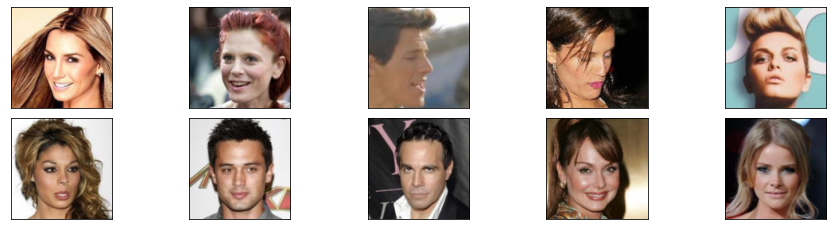

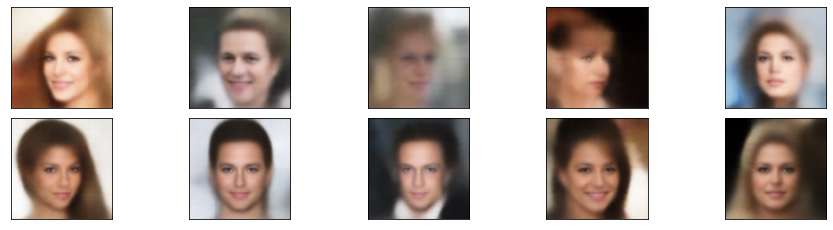

In [7]:
images = torch.stack([data.celeba_train[i][0] for i in range(10)]).to(device)
reconstructions = vae.predict_step(images)
display_img(images)
display_img(reconstructions)

### Generated celebrities

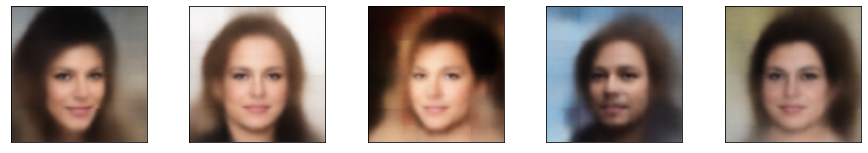

In [8]:
sample = torch.randn(5, Z_DIM).to('cuda')
display_img(vae.decode(sample).to('cpu'))

### Modifying features

Let's try modifying celebrities gender. Find space vector responsible for transformation from male to female.

In [9]:
GENDER_FEATURE_IDX = 20

In [11]:
female_encodings = []
num_female = 0
male_encodings = []
num_male = 0

loader = data.train_dataloader()

for i, batch in enumerate(loader):
    with torch.no_grad():
        x, labels = batch
        x = x.to(device)
        z_mean, z_log_var = vae.encode(x)
        encodings = vae.sample_z(z_mean, z_log_var)
        males_vectors = encodings[(labels[:, GENDER_FEATURE_IDX] == 1).nonzero().squeeze(1)]
        females_vectors = encodings[(labels[:, GENDER_FEATURE_IDX] == 0).nonzero().squeeze(1)]
        male_encodings.append(torch.sum(males_vectors, dim=0))
        num_male += males_vectors.size()[0]
        female_encodings.append(torch.sum(females_vectors, dim=0))
        num_female += females_vectors.size()[0]

In [24]:
male_vector = torch.sum(torch.stack(male_encodings), 0) / num_male
female_vector = torch.sum(torch.stack(female_encodings), 0) / num_female

In [25]:
male_to_female = female_vector - male_vector

In [72]:
z_mean, z_log_var = vae.encoder(data.celeba_train[6][0].view(-1, 3, 128, 128).to(device))
vector = vae.sample_z(z_mean, z_log_var)

In [85]:
images = []
for i in range(8):
    images.append(vector + (i * male_to_female))

In [86]:
result = vae.decoder(torch.stack(images))
result.size()

torch.Size([8, 3, 128, 128])

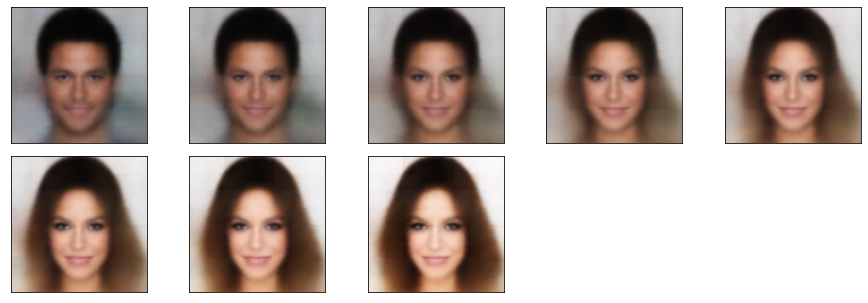

In [87]:
display_img(result)